In [133]:
import numpy as np
import flopy
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import os
import csv
import time
from scipy.stats import pearsonr
from flopy.utils.sfroutputfile import SfrFile

from scipy.interpolate import interp2d
from scipy.interpolate import griddata
import matplotlib.cm as cm

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Classifier
from sklearn.tree import ExtraTreeRegressor

from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV

import importlib
import treeFuncs
from treeFuncs import trainAndEvaluateModel 
from treeFuncs import metrics


modws ="C:/Users/davem/Documents/Thesis/modflow/mfoutput"
#modws= "D:/mfoutput/transientDrawdown"
modws= "D:/mfoutput/transientSeasons"

In [237]:
col_names = ['K', 'Low_K_ratio', 'Sy', 'Rech', 'ET_valley', 'ET_rip_ratio', 'Stream_K_ratio']#, 'Qout']

# load output from modflow simulations
#outputdf = pd.read_csv('outputs/TransOutputStpSteadyPumpTest.csv') 
outputdf = pd.read_csv('outputs/TransSeasonsOutputStpTest.csv') #output

#load parameters
sampling = np.loadtxt("params/ModflowParams7-750Test12.txt") 
print(sampling)
pardf = pd.DataFrame(sampling, columns = col_names)

outputdf = outputdf[['simnum','Qout','reach','Stp']].reset_index() #only keep the cols we need

#Drawdown scenario steps
numTS = 5 #number of time steps to keep from the end
stps = 5 - numTS

#Seasonal Scenario Steps
numTS = 6 #number of time steps to keep from the end
stps = 41 - numTS

StrPer = [i+1 for i in range(stps, stps+numTS)]
print(StrPer)
outputdf = outputdf[outputdf['Stp'] > stps].set_index(['Stp','simnum','reach']) #grab data from the last 5 stress periods and set index to simulation
simindex = outputdf.index.get_level_values('simnum').unique()
timestepidx = outputdf['index'].unique()
idx = pd.IndexSlice

pardf = pardf.iloc[simindex]
outputdf = outputdf.drop('index', axis=1).unstack('reach')
#print(outputdf.columns)
outputdf = outputdf.droplevel(0, axis=1)
#display(outputdf[25])

[[3.19247919e-01 1.88302730e-04 1.37480374e-01 ... 1.60372088e-06
  4.69038871e+00 1.63449723e-02]
 [2.52595828e-01 7.43633707e-05 5.80341431e-02 ... 8.79813703e-06
  3.18511742e+00 1.12193189e-02]
 [4.25212558e-01 7.61486276e-01 1.08251212e-01 ... 2.16034275e-06
  2.18084489e+00 1.21442097e-03]
 ...
 [4.39468577e-01 6.13132403e-02 2.12593341e-01 ... 3.75793109e-06
  1.89596277e+00 4.01859879e-02]
 [2.86647520e-01 1.19454051e-05 9.47905228e-02 ... 1.42520917e-06
  2.77129655e+00 7.38527223e-02]
 [2.63331106e-01 2.82770295e-05 1.23301509e-01 ... 6.47036236e-06
  1.38885456e+00 1.12791618e-03]]
[36, 37, 38, 39, 40, 41]


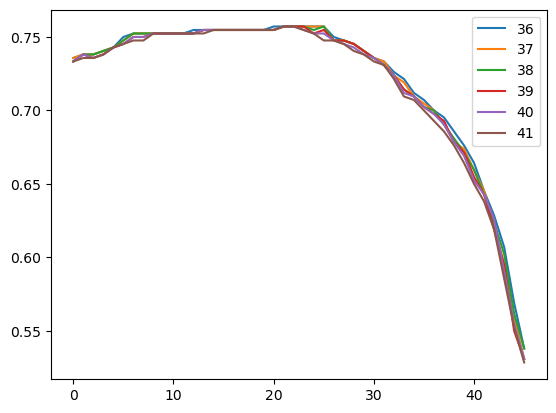

23
(420, 50)
Int64Index([  1,   2,   3,   4,   6,   7,   8,   9,  10,  11,
            ...
            737, 739, 740, 741, 742, 743, 744, 745, 748, 749],
           dtype='int64', name='simnum', length=2520)
318


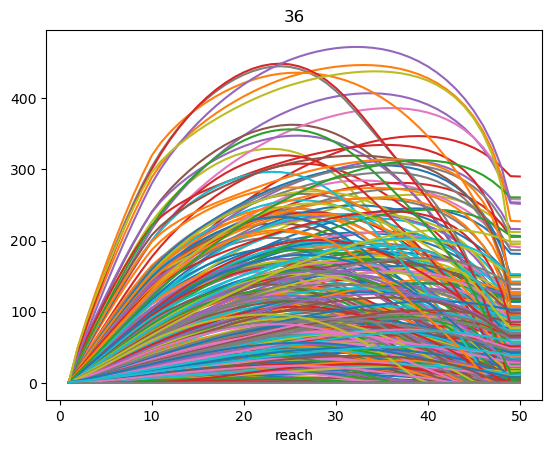

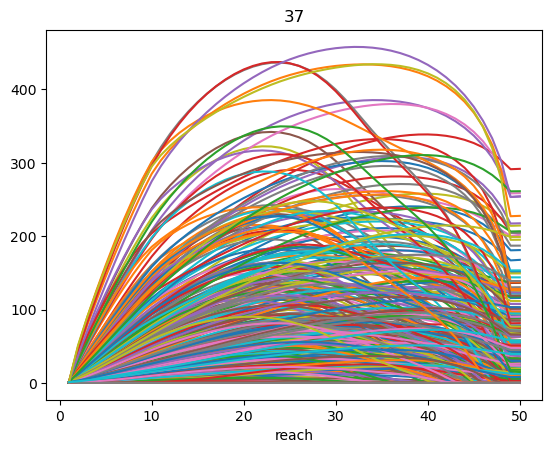

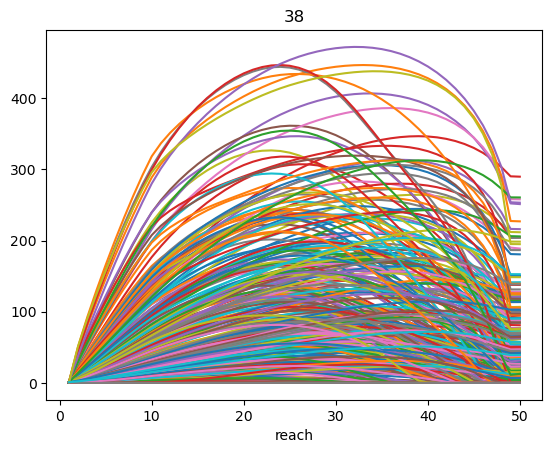

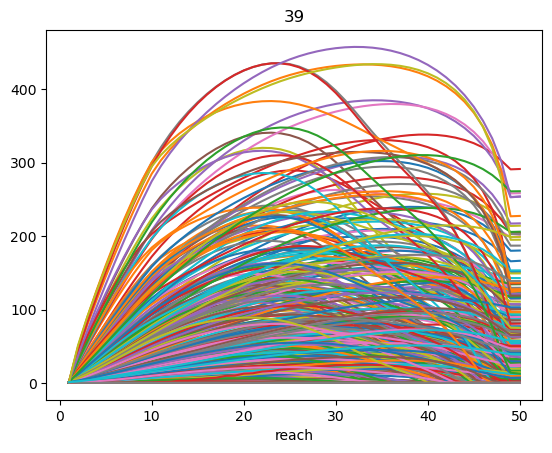

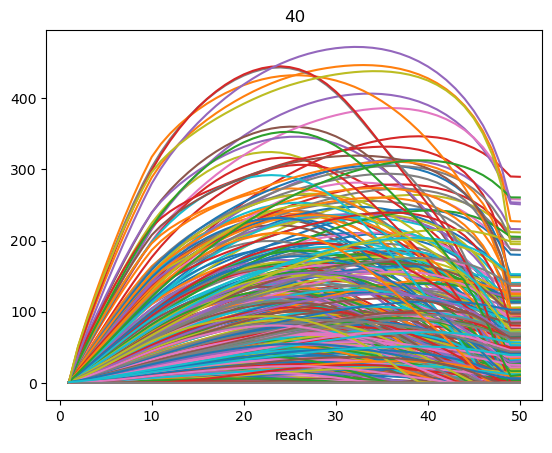

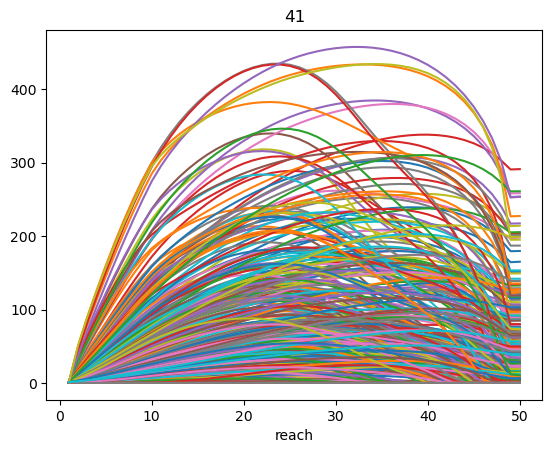

In [238]:
#Getting rid of ensembles with 0 flow
rn = 25

for i in StrPer:
    ReachQdf = outputdf.xs(i,level='Stp')

    numgrz = [np.sum(ReachQdf[k] > 0) / len(ReachQdf.index) for k in range(1,51)] 
   # print(numgrz.index(max(numgrz[2:])))
    plt.plot(numgrz[2:48], label=i)
   # print(ReachQdf.index)
#ReachQdf = pd.DataFrame(np.asarray(outputdf[outputdf['Stp'] == 5]['Qout']).reshape((len(simindex),50))) #this is ugly
plt.legend()
#numgrz = [len(ReachQdf[i][ReachQdf[i] > 0].index)/len(ReachQdf.index) for i in range(50)] 
#print(numgrz.index(max(numgrz)))
plt.show()
#print(ReachQdf.index)

rn_highest = numgrz.index(max(numgrz[2:])) #find reach with greatest number of wet ensembles 
#ReachQdf = ReachQdf[ReachQdf[rn_highest] > 0]
print(rn_highest)
print(ReachQdf.shape)

#New way of pulling out simulations that are dry using multi-level index

print(outputdf.index.get_level_values('simnum'))

HighRn = outputdf[rn_highest] #get a slice of the highest reach Qout
grtzSims = HighRn[HighRn > 0].index.get_level_values('simnum').unique().values
print(len(grtzSims))
idx = pd.IndexSlice #makes slicing multilevel indexs easier
RevisedOutputdf = outputdf.loc[idx[:,grtzSims,:] , :]
#display(RevisedOutputdf)
#display(outputdf)
pardf = pardf.loc[grtzSims]

for l in StrPer:
    LastStpQdf = outputdf.xs(l,level='Stp')
    for i in LastStpQdf.index:
        LastStpQdf.loc[i].plot(title="Streamflows for Stress Period " + str(l))
    plt.show()

# Decision Tree Code
Most of below is from:https://www.datacamp.com/community/tutorials/decision-tree-classification-python

## Now for the Wells

In [239]:
#all_well_loc = np.array(np.meshgrid(np.arange(50),np.arange(50))).T.reshape(-1,2)
#print(all_well_loc)

#load in Ibound and find active cells in model - then put it into a list of well locations
ibound = np.loadtxt('base/ibound_lyr1.txt')            
all_well_loc = np.asarray(np.where(ibound == 1)).T

#well_head = np.empty((all_well_loc.shape[0], len(simindex),numTS))
well_head = np.empty((all_well_loc.shape[0], len(grtzSims),numTS))



In [240]:
# #Cell block for test head object out put - can ignore 

# modelname = "ScenarioSfr750Seasons_"+str(simindex[0])
# headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
# head = headobj.get_alldata(mflay = 0, nodata=-9.9998999e+02)
# print(head.shape)
# print(head[::30,21,32][-6:])
# headtimes = np.array(headobj.get_times())
# print(headtimes)

# print(headtimes[::30])
# print(len(headtimes[::30]))

# headts = headobj.get_ts([(0,21,32)])
# #headts[10:,0] = (headts[10:,0] / 6) * 50  *2
# print(headts[::30][-numTS:].astype('int'))
# print(headobj.get_ts([(0,21,32)])[::30,1][-numTS:].astype('int'))


# print(len(headts))
# headstp = np.divmod(np.arange(len(headts)-10),30*2)[0]+1

# plt.plot(headts[::30,1])
# plt.show()
# plt.plot(headts[:,1])

In [ ]:
#Get Head data for All active wells
#import seaborn as sns
sns.set_style("white")
modws= "D:/mfoutput/transientSeasons"
#well_head = np.empty((all_well_loc.shape[0], len(simindex),numTS))
well_error_sim = []
#well_error_num = []

for j, i in enumerate(grtzSims):
    modelname = "ScenarioSfr750SeasonsTest_"+str(i)
    headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
#     for k in range(all_well_loc.shape[0]):
#         well_head[k][j][:] = headobj.get_ts([(0,int(all_well_loc[k][0]),int(all_well_loc[k][1]))])[::30,1][-numTS:] #complicated way of getting all the heads (numTS) by sampling every 30 of the head ts foreach well
#         if (np.any(well_head[k][j][:]) < 0) or (np.any(well_head[k][j][:]) > 200) or np.any(np.isnan(well_head[k][j][:])):
#                 well_error_sim.append(i)              
                
    head = headobj.get_alldata(mflay = 0, nodata=-9.9998999e+02)
    for k in range(all_well_loc.shape[0]): #grabbing the last n Stress periods (-numTS)
            well_head[k][j][:] = head[::30,int(all_well_loc[k][0]),int(all_well_loc[k][1])][-numTS:] #Data from the wells is at timestep 0 for first or -1, if we wanna grab the last two it would 
           # well_head[k][j][1] = head[-1][0][int(all_well_loc[k][0])][int(all_well_loc[k][1])] #Data from the wells is at timestep 0 for first or -1, if we wanna grab the last two it would  be 60
            if (np.any(well_head[k][j][:]) < 0) or (np.any(well_head[k][j][:]) > 200) or np.any(np.isnan(well_head[k][j][:])):
                well_error_sim.append(i)
print("Done")          

In [ ]:
## Delete out simulations where well head is twice the average
print(well_head.shape)
#print(well_head.transpose(1,0,2).reshape(len(simindex),well_head.shape[0]*numTS))
RevisedPardf = pardf.loc[~pardf.index.isin(np.unique(well_error_sim))]
#new_zone.head
well_head_df = pd.DataFrame(well_head.transpose(1,0,2).reshape(len(grtzSims),well_head.shape[0]*numTS),index=grtzSims)#, index = pardf.index) #put the wwells into an unput that has each stress period so now input os 4024 long
display(well_head_df)
print(len(well_head_df.index))

#well_head_df.to_pickle('outputs/heads/Well_head_seasons.pkl')
#RevisedPardf.to_pickle('params/Seasons_pardf.pkl')   
print(len(well_head_df.index))
print(RevisedPardf)




In [241]:
#Only necessary if pulling well_head_df from pkl or csv

#well_head_df = pd.read_pickle('outputs/heads/Well_head_drawdown.pkl')
well_head_df = pd.read_pickle('outputs/heads/Well_head_seasons.pkl')

#new_zone = pd.read_pickle('params/Drawdown_pardf.pkl')
new_zone = pd.read_pickle('params/Seasons_pardf.pkl')

well_head = np.empty((all_well_loc.shape[0], len(simindex),numTS))
well_heads_loc = np.arange(all_well_loc.shape[0]*numTS).reshape((int(all_well_loc.shape[0]),numTS)) #splits the well head_df into subsets aplicable to the location (so we ahve numTS outputs)

wellnums_arr = np.arange(well_head.shape[0])
stps_arr = StrPer
column_idx = pd.MultiIndex.from_product([wellnums_arr.astype('str'), stps_arr],
                           names=['wellnum', 'Stp'])
well_head_df.columns = column_idx

display(well_head_df)

wellnum           0                                                  \
Stp              36          37          38          39          40   
1        100.947212  100.943222  100.939056  100.935188  100.931114   
2         99.750465   99.712372   99.674309   99.636322   99.598457   
3        100.362366  100.353127  100.343575  100.333717  100.323479   
6         97.486771   97.465065   97.439606   97.418259   97.393150   
7        100.579979  100.560577  100.541008  100.521278  100.501411   
..              ...         ...         ...         ...         ...   
742      107.361809  107.360550  107.358917  107.357780  107.356262   
743       93.388260   93.371178   93.332642   93.316154   93.278214   
744       93.971336   93.966354   93.961098   93.955833   93.950363   
748      103.653870  103.654572  103.655258  103.655922  103.656525   
749       98.082314   98.081413   98.080460   98.079529   98.078537   

wellnum                       1                                      ...  \
Stp              41          36          37          38          39  ...   
1        100.927330  100.701523  100.697456  100.693352  100.689392  ...   
2         99.560699   99.503525   99.465179   99.426880   99.388687  ...   
3        100.313087  100.132065  100.122528  100.112663  100.102463  ...   
6         97.372131   97.236900   97.219040   97.190025   97.172516  ...   
7        100.481422  100.332970  100.313255  100.293381  100.273338  ...   
..              ...         ...         ...         ...         ...  ...   
742      107.355202  107.068184  107.066818  107.065308  107.064056  ...   
743       93.262276   93.172318   93.150993   93.116806   93.096085  ...   
744       93.945038   93.774445   93.769455   93.763885   93.758705  ...   
748      103.657120  103.383713  103.384415  103.385078  103.385727  ...   
749       98.077621   97.869987   97.869080   97.868118   97.867180  ...   

wellnum       2010                                        2011             \
Stp             38         39         40         41         36         37   
1        94.918785  94.913712  94.908867  94.903961  94.603149  94.597885   
2        94.133789  94.105339  94.076935  94.048485  93.854149  93.825554   
3        94.597198  94.587219  94.577087  94.566917  94.284721  94.274788   
6        93.040985  93.028786  93.017067  93.004745  92.797356  92.785591   
7        94.676277  94.663857  94.651382  94.638878  94.366570  94.354050   
..             ...        ...        ...        ...        ...        ...   
742      99.819481  99.817291  99.814789  99.812767  99.425453  99.423111   
743      89.623306  89.603996  89.587303  89.567978  89.424553  89.405449   
744      89.369110  89.364891  89.361862  89.357513  89.107132  89.102905   
748      97.242516  97.242462  97.242393  97.242355  96.916084  96.916016   
749      93.123878  93.122223  93.120552  93.118896  92.846779  92.845070   

wellnum                                              
Stp             38         39         40         41  
1        94.592873  94.587761  94.582893  94.577965  
2        93.797020  93.768486  93.739990  93.711479  
3        94.264763  94.254532  94.244232  94.233887  
6        92.774338  92.762405  92.751015  92.738930  
7        94.341507  94.328903  94.316261  94.303574  
..             ...        ...        ...        ...  
742      99.420387  99.418221  99.415680  99.413704  
743      89.389069  89.369919  89.353493  89.334305  
744      89.099937  89.095573  89.092537  89.088066  
748      96.915894  96.915840  96.915733  96.915688  
749      92.843369  92.841682  92.839981  92.838303  

[318 rows x 12072 columns]

In [242]:
Corrmatrix = LastStpHeads.corr()

C:\Users\davem\AppData\Local\Temp\ipykernel_18508\3972143253.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r",lut=30)


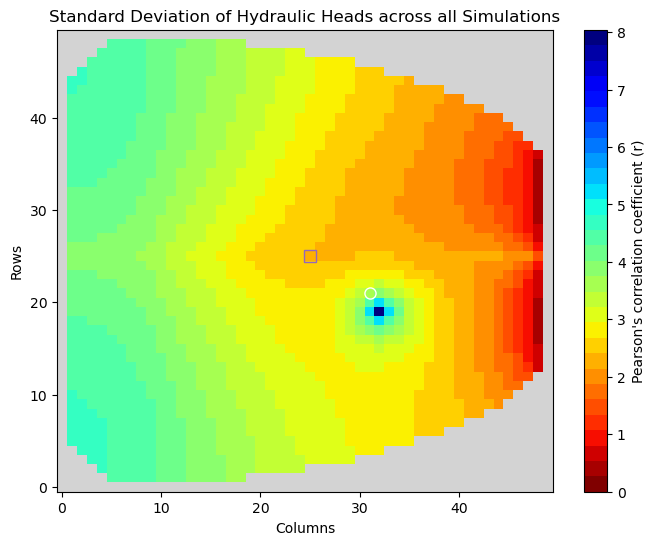

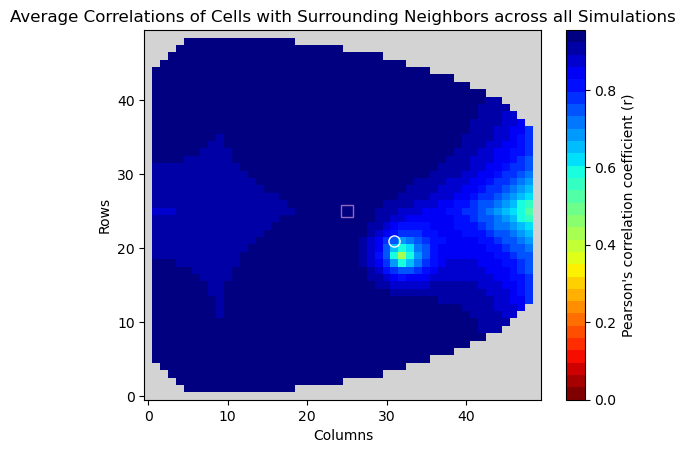

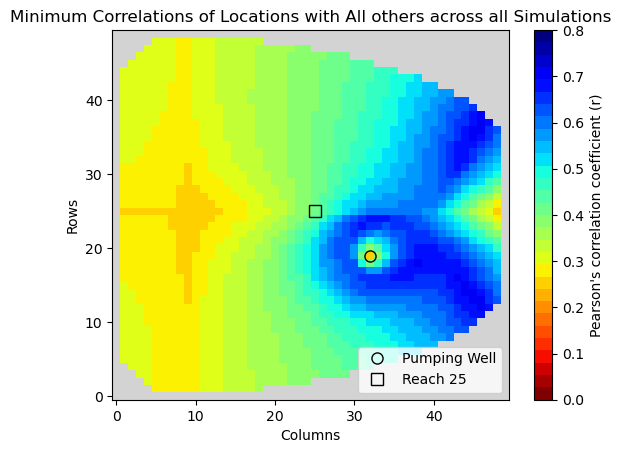

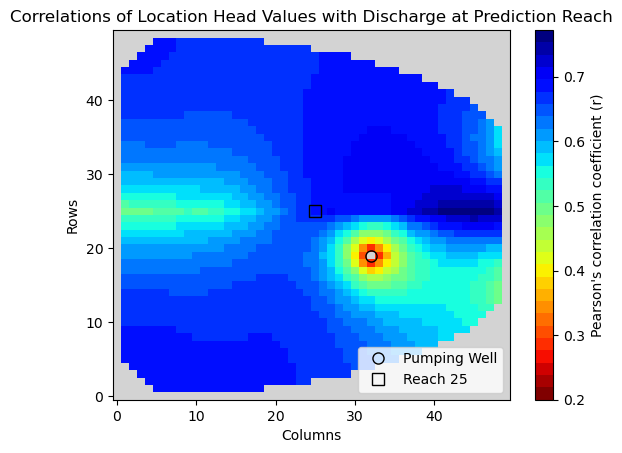

In [247]:

ztop = np.genfromtxt('base/base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)


kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)

# print(well_head_var)
wellmesh = np.ndarray((50,50))
wellmesh[:][:] = -1e30

wellmesh2 = wellmesh.copy()
mesh_feat_to_target = wellmesh.copy()
wellmesh_corr = wellmesh.copy()
minmesh = wellmesh.copy()

from spotpy.objectivefunctions import correlationcoefficient as r
new_zone_q = ReachQdf.loc[well_head_noRiv.index]

rn = 25

LastStpHeads = well_head_df.loc[:,idx[:,StrPer[-1]]]
outputs = RevisedOutputdf.loc[idx[StrPer[-],:],rn].unstack('Stp')


for i in range(all_well_loc.shape[0]):
    wellmesh[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = LastStpHeads[str(i)].std()
    mesh_feat_to_target[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = r(outputs.values.flatten(),LastStpHeads[str(i)].values.flatten())
   # wellmesh2[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = LastStpHeads[str(i)].mean() - ztop[int(all_well_loc[i, 0]),int(all_well_loc[i, 1])]
    wellmesh_corr[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = Corrmatrix[str(i)].mean()
    minmesh[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = Corrmatrix[str(i)].min()
    
cmap2 = cm.get_cmap("jet_r",lut=30)
cmap2.set_under("lightgray")
river = np.ndarray((48,))
river[:] = 25
plt.figure(figsize=(8,6))

reach_label = "Reach " + str(rn)

plt.pcolormesh(KK,GG,wellmesh,cmap = cmap2,vmin=0.0, shading='nearest')
plt.colorbar(label = 'Pearson\'s correlation coefficient (r)')
plt.plot(int(all_well_loc[wn][1]), int(all_well_loc[wn][0]), marker="o", markersize=8, color="White", mfc='none', linestyle = "None", label="Plot Location")
plt.plot(rn,25, marker="s", markersize=8, color="tab:purple", mfc='none', linestyle = "None", label=reach_label)
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Standard Deviation of Hydraulic Heads across all Simulations')
plt.show()


plt.pcolormesh(KK,GG,wellmesh_corr,cmap = cmap2,vmin=0.0, shading='nearest')
plt.colorbar(label = 'Pearson\'s correlation coefficient (r)')
plt.plot(int(all_well_loc[wn][1]), int(all_well_loc[wn][0]), marker="o", markersize=8, color="White", mfc='none', linestyle = "None", label="Plot Location")
plt.plot(rn,25, marker="s", markersize=8, color="tab:purple", mfc='none', linestyle = "None", label=reach_label)
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Average Correlations of Cells with Surrounding Neighbors across all Simulations')
plt.show()
# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')

# #plt.imshow(wellmesh, cmap='RdBu')

plt.pcolormesh(KK,GG,minmesh,cmap = cmap2,vmin=0, vmax = 0.8, shading='nearest')
plt.colorbar(label = 'Pearson\'s correlation coefficient (r)')
plt.plot(32,19, marker="o", markersize=8, color="k", mfc='none', linestyle = "None", label="Pumping Well")
plt.plot(rn,25, marker="s", markersize=8, color="k", mfc='none', linestyle = "None", label=reach_label)
plt.legend(loc='lower right')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Minimum Correlations of Locations with All others across all Simulations')
plt.show()

plt.pcolormesh(KK,GG,mesh_feat_to_target,cmap = cmap2, vmin = 0.2, shading='nearest')
plt.colorbar(label = 'Pearson\'s correlation coefficient (r)')
plt.plot(32,19, marker="o", markersize=8, color="k", mfc='none', linestyle = "None", label="Pumping Well")
plt.plot(rn,25, marker="s", markersize=8, color="k", mfc='none', linestyle = "None", label=reach_label)
plt.legend(loc='lower right')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Correlations of Location Head Values with Discharge at Prediction Reach')
plt.show()

## Using Wells to predict stream Flow

In [248]:
# Since we changed the number of wells - use this for flow only outputs
#well_df = pd.DataFrame(new_well_head.transpose(), index = new_zone.index)

river_well_loc = np.where(all_well_loc[:,0] == 25)
#river_well_loc = np.where((all_well_loc[:,0] > 23) & (all_well_loc[:,0] < 27))

CHBound_loc = np.where(all_well_loc[:,1] >47) #
drop_locs= np.concatenate((river_well_loc, CHBound_loc), axis = 1)

AllWells = np.arange(all_well_loc.shape[0])

noRivWells = [str(i) for i in AllWells if i not in drop_locs[0]]
print(len(noRivWells))

well_head_noRiv = well_head_df.loc[:,idx[noRivWells,:]]  

well_loc_df = pd.DataFrame(all_well_loc).drop(drop_locs[0])
#display(well_loc_df)
#print(well_head_noRiv.shape)
#display(well_head_noRiv)

1941


In [249]:
#display(well_head_noRiv)

## Testing stacking all the stressperiods together to increase the sample sizes
Stp_head_test_df = well_head_noRiv.copy()
noRivWellsInt = [i for i in AllWells if i not in drop_locs[0]]

column_idx = pd.MultiIndex.from_product([noRivWellsInt, stps_arr],
                           names=['wellnum', 'Stp'])
Stp_head_test_df.columns = column_idx
# Stp_head_test_df.columns = Stp_head_test_df.columns.astype('str')
#display(Stp_head_test_df)
Stp_head_test_df = Stp_head_test_df.stack(level='Stp').reset_index(drop=True)
display(Stp_head_test_df)
output_test = RevisedOutputdf.swaplevel(0,1).sort_index(0)
#display(RevisedOutputdf[25])
output_test = output_test.reset_index(drop=True)
#display(RevisedOutputdf.loc[idx[:,1],25])

Stp_head_test_df.columns = Stp_head_test_df.columns.astype('str')

wellnum,0,1,2,3,4,5,6,7,8,9,...,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011
0,100.947212,100.701523,100.294678,99.792885,99.199348,98.688461,98.155624,97.613716,97.070427,96.532211,...,99.061127,98.550766,98.018639,97.477623,96.935333,96.398224,95.874001,95.375374,94.929001,94.603149
1,100.943222,100.697456,100.290398,99.788170,99.193954,98.683769,98.151222,97.609375,97.066040,96.527748,...,99.055138,98.545555,98.013763,97.472794,96.930450,96.393227,95.868912,95.370209,94.923775,94.597885
2,100.939056,100.693352,100.286469,99.784630,99.191048,98.680023,98.147057,97.605026,97.061623,96.523308,...,99.052010,98.541473,98.009186,97.467995,96.925560,96.388306,95.863976,95.365250,94.918785,94.592873
3,100.935188,100.689392,100.282295,99.780029,99.185760,98.675438,98.142769,97.600792,97.057350,96.518936,...,99.046173,98.536407,98.004448,97.463333,96.920845,96.383492,95.859047,95.360229,94.913712,94.587761
4,100.931114,100.685379,100.278465,99.776596,99.182953,98.671799,98.138702,97.596558,97.053047,96.514626,...,99.043175,98.532478,98.000023,97.458679,96.916100,96.378723,95.854263,95.355423,94.908867,94.582893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1903,98.081413,97.869080,97.518982,97.089714,96.583885,96.173500,95.739349,95.293289,94.842239,94.392075,...,96.568535,96.158203,95.723915,95.277504,94.826042,94.375290,93.932098,93.507744,93.125549,92.845070
1904,98.080460,97.868118,97.518036,97.088821,96.583115,96.172539,95.738304,95.292168,94.841095,94.390877,...,96.567429,96.156876,95.722488,95.276031,94.824532,94.373741,93.930519,93.506119,93.123878,92.843369
1905,98.079529,97.867180,97.517044,97.087738,96.581871,96.171448,95.737221,95.291077,94.839951,94.389679,...,96.565834,96.155441,95.721077,95.274590,94.823044,94.372200,93.928917,93.504486,93.122223,92.841682
1906,98.078537,97.866188,97.516068,97.086823,96.581093,96.170456,95.736153,95.289955,94.838791,94.388481,...,96.564751,96.154121,95.719658,95.273117,94.821541,94.370651,93.927345,93.502869,93.120552,92.839981


C:\Users\davem\AppData\Local\Temp\ipykernel_18508\2421804134.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  output_test = RevisedOutputdf.swaplevel(0,1).sort_index(0)


In [297]:
best_pars_dt = {'min_samples_split': 15, 'min_samples_leaf': 5, 'min_impurity_decrease': 15, 'max_leaf_nodes': 234, 'max_depth': 8, 'criterion': 'squared_error','random_state': 29}

#Previous
#best_pars_dt = {'splitter': 'best', 'min_samples_split': 15, 'min_samples_leaf': 2, 'min_impurity_decrease': 35, 'max_leaf_nodes': 263, 'max_features': 1.0, 'max_depth': 7, 'criterion': 'friedman_mse', 'random_state':1}

In [298]:
importlib.reload(treeFuncs)
from treeFuncs import trainAndEvaluateModel

# Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n = 1

random_state = 29

rn = 25
strper_num = 0
#StrPer = [i+1 for i in range(stps, stps+numTS)]

#take the last stress period (-1) - welldf columns are strings 
SingleStpHeads = well_head_noRiv.loc[:,idx[:,StrPer[-1]]]
SingleStpHeads.columns = SingleStpHeads.columns.droplevel('Stp').astype('str') #have to do this for the TreeRegressor to keep the wellnums
outputs = RevisedOutputdf.loc[idx[StrPer[-1],:],rn].unstack('Stp')
#display(outputs)

imp_df, metrics_df, impurity, Tree, y_test, y_pred = trainAndEvaluateModel(DecisionTreeRegressor, SingleStpHeads, outputs, best_pars_dt, 0.2, n, random_state)  

#imp_df, metrics_df, y_test, y_pred = trainAndEvaluateModel(DecisionTreeRegressor, Stp_head_test_df, outputs[rn], best_pars_dt, 0.2, n)  

print('Total time: ' + str(time.time()-t0))


Shape of Input Samples: (318, 1941)
Shape of Output Targets: (318, 1)
Total time: 0.8232383728027344


       bias       rmse         r       nse    lognse       kge
0  8.062066  43.348166  0.830392  0.654702  0.710739  0.814797


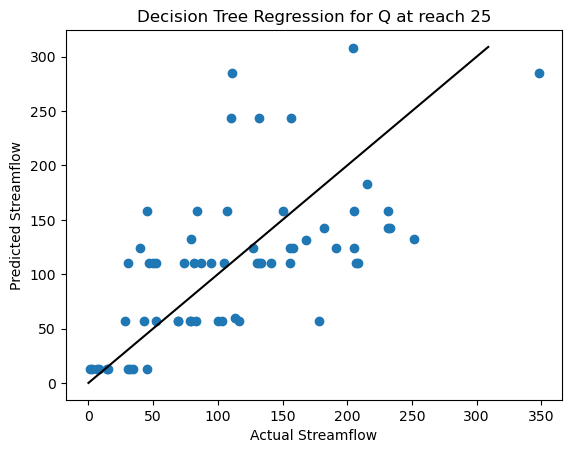

[0.4868916420965106, 0.1845879037197955, 0.05850962320063745]


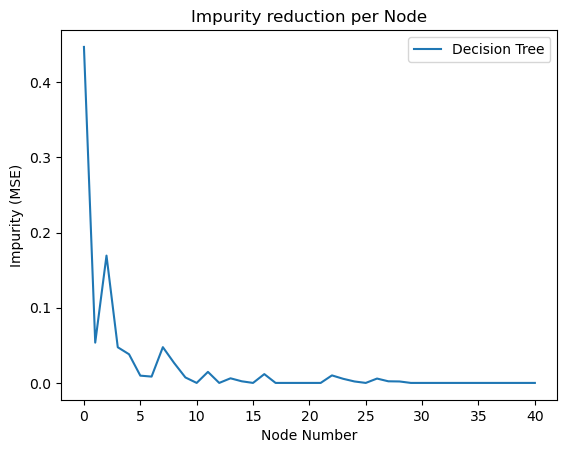

In [302]:
print(metrics_df)
# display(imp_df)
# test = imp_df.copy().T
#test.columns =Stp_head_test_df.columns
#test.columns = well_head_noRiv.columns
#test = pd.DataFrame(test.sum(axis = 0) / n)

#display(test)


# #imp_df.to_pickle('Drawdown_DT_Impdf.pkl')
plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_pred.max()) +1
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Decision Tree Regression for Q at reach " + str(rn)
plt.title(title)
plt.show()

import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import quickEvalTree

impurity_df = pd.DataFrame(impurity).fillna(0)
avg_impurity = impurity_df.mean(axis = 0)

#print(Tree.max_features_)
#print(Tree.n_features_in_)
print(sorted(Tree.feature_importances_, reverse=True)[:3])
from treeFuncs import evalTree
imp_improv = quickEvalTree(Tree)

plt.plot(imp_improv, label = "Decision Tree")
#plt.plot(rand_imp_improv, label ="Random Tree")
#plt.plot(avg_rand_impurity, label ="Avg Random Tree")
plt.title('Impurity reduction per Node')
plt.ylabel('Impurity (MSE)')
plt.xlabel('Node Number')
plt.legend()
#help(tree._tree.Tree)

## RandomTree

Shape of Input Samples: (318, 1941)
Shape of Output Targets: (318, 1)
Total time: 9.350804805755615
bias       1.501204
rmse      56.241512
r          0.698947
nse        0.411054
lognse     0.651439
kge        0.683444
dtype: float64


Text(0.5, 1.0, 'Example Random Decision Tree Regression for Q at reach 25')

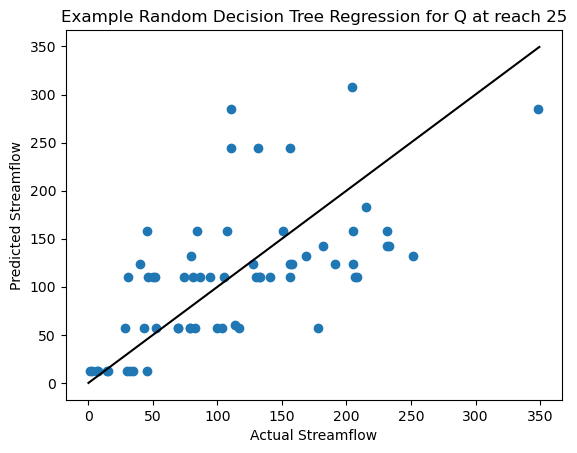

In [299]:
# RANDOM Tree 
# Split dataset into training set and test set, default here is 30% test
t0 = time.time()


#Splitter is random and max features is set to 1, note that 1.0 is all in the new Sklearn so this is a little confusing
best_pars_dt_rand = {'splitter': 'best', 'max_features': 1, 'min_samples_split': 15, 'min_samples_leaf': 5, 'min_impurity_decrease': 15, 'max_leaf_nodes': 234, 'max_depth': 8, 'criterion': 'squared_error'}

#best_pars_dt_rand = {'splitter': 'best', 'min_samples_split': 15, 'min_samples_leaf': 2, 'min_impurity_decrease': 35, 'max_leaf_nodes': 263, 'max_features': 1, 'max_depth': 7, 'criterion': 'friedman_mse'}
    
n=100
imp_df_rand, metrics_df_rand, rand_impurity_list, randTree, y_test, y_pred = trainAndEvaluateModel(ExtraTreeRegressor, SingleStpHeads, outputs, best_pars_dt_rand, 0.2, n, random_state)  

#imp_df_rand, metrics_df_rand, y_test, y_pred = trainAndEvaluateModel(ExtraTreeRegressor, Stp_head_test_df, output_test[rn], best_pars_dt_rand, 0.2, n, random_state)  

t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

#print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[rn]> 0].index) / len(new_zone_q.index)))

#print(metrics_df_rand.mean(),metrics_df_rand.std())
print(metrics_df_rand.mean())
plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_test.max()) +1
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Example Random Decision Tree Regression for Q at reach " + str(rn)
plt.title(title)

C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:119: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)
C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:119: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


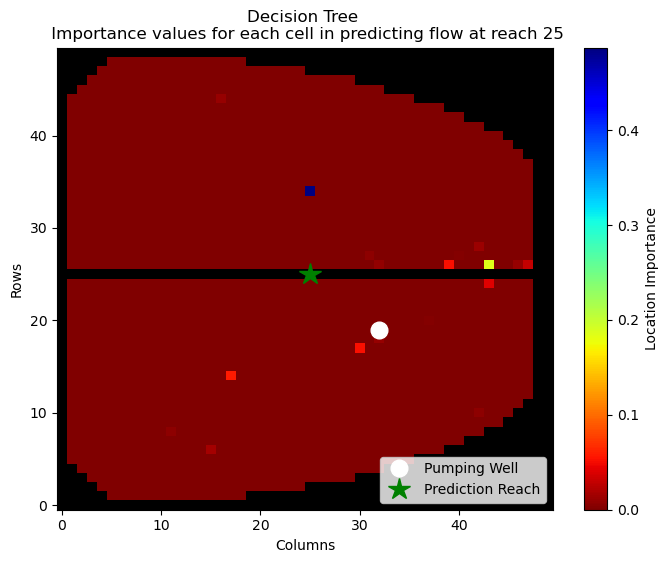

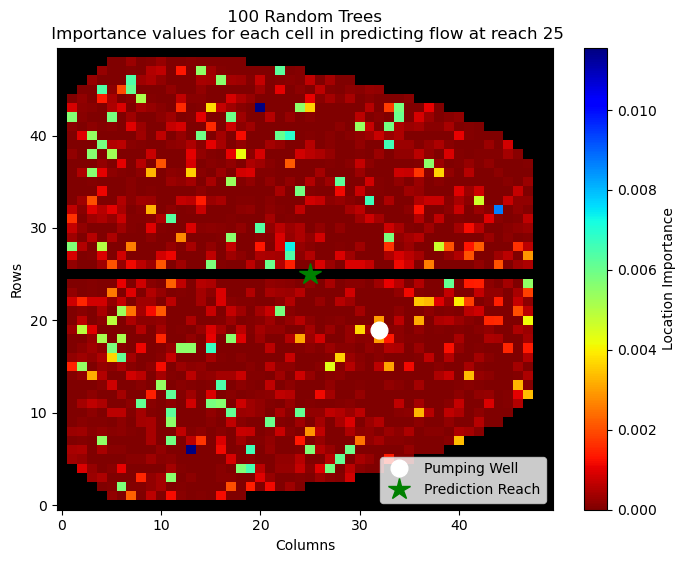

In [301]:
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import plotImportance

numTS = 1

title = 'Decision Tree \n Importance values for each cell in predicting flow at reach ' + str(rn)
#wellmesh_df = np.ndarray((len(StrPer),50,50))


#for k,i in enumerate(StrPer):
 #   wellmesh_df[k] = plotImportance(test.xs(i,level='Stp'),SingleStpHeads, well_loc_df,numTS,n,rn,title)
wellmesh_df = plotImportance(imp_df,SingleStpHeads, well_loc_df,numTS,1,rn,title)

title_rand = ' 100 Random Trees \n Importance values for each cell in predicting flow at reach ' + str(rn)

wellmesh_rand = plotImportance(imp_df_rand,SingleStpHeads, well_loc_df,numTS,100,rn,title_rand)


250
            0         1         2    3    4    5    6
0    0.329142  0.119005  0.061323  0.0  0.0  0.0  0.0
1    0.421639  0.021389  0.063257  0.0  0.0  0.0  0.0
2    0.261789  0.243472  0.009216  0.0  0.0  0.0  0.0
3    0.388418  0.067239  0.047670  0.0  0.0  0.0  0.0
4    0.421980  0.074521  0.035383  0.0  0.0  0.0  0.0
..        ...       ...       ...  ...  ...  ...  ...
995  0.409124  0.054724  0.064054  0.0  0.0  0.0  0.0
996  0.419022  0.018886  0.045623  0.0  0.0  0.0  0.0
997  0.207975  0.195915  0.008988  0.0  0.0  0.0  0.0
998  0.344957  0.019455  0.128221  0.0  0.0  0.0  0.0
999  0.408783  0.081119  0.043120  0.0  0.0  0.0  0.0

[1000 rows x 7 columns]


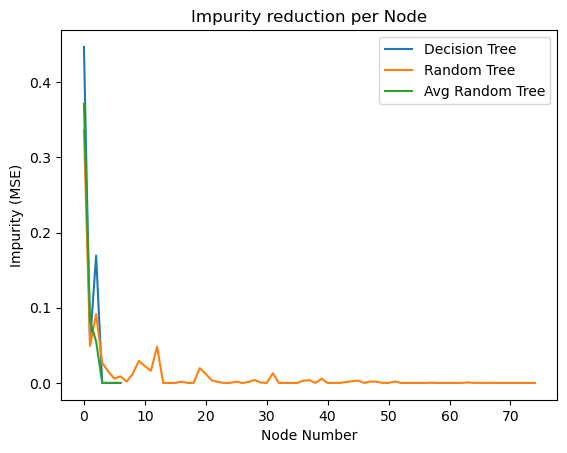

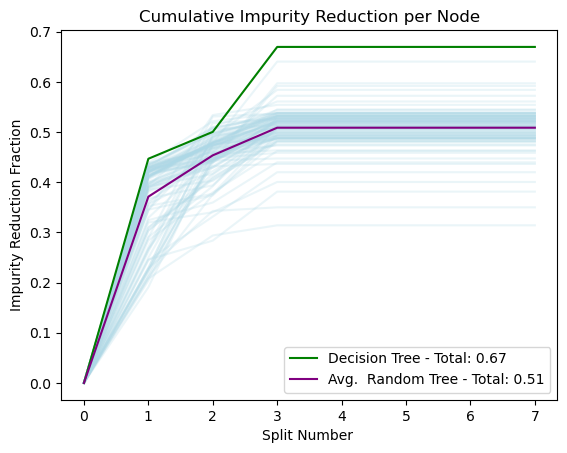

In [296]:
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import evalTree

impurity_df = pd.DataFrame(rand_impurity_list).fillna(0)
avg_rand_impurity = impurity_df.mean(axis = 0)

max_rand_idx = impurity_df.iloc[:,:2].sum(axis=1).idxmax()
print(max_rand_idx)
print(impurity_df)
max_rand_impurity = impurity_df.loc[max_rand_idx]

min_rand_idx = impurity_df.sum(axis = 1).idxmin()
min_rand_idx = impurity_df[0].idxmin()

min_rand_impurity = impurity_df.loc[min_rand_idx]
#display(impurity_df)
#print(Tree.max_features_)
#print(Tree.n_features_in_)
#print(sorted(randTree.feature_importances_, reverse=True)[:3])
#from treeFuncs import evalTree
#rand_imp_improv = evalTree(randTree)

plt.plot(imp_improv, label = "Decision Tree")
plt.plot(rand_imp_improv, label ="Random Tree")
plt.plot(avg_rand_impurity, label ="Avg Random Tree")
plt.title('Impurity reduction per Node')
plt.ylabel('Impurity (MSE)')
plt.xlabel('Node Number')
plt.legend()
#help(tree._tree.Tree)
plt.show()

#quick cumulative function that inserts 0 at beginning 
def cumImpurity(imp):
    nodes = 10
    return np.cumsum(np.insert(imp,0,0))[:nodes] #inserting 0 at the beginning - essentially to indicate the original impurity reduction (0)



dt_impurity_cumulative = cumImpurity(imp_improv)
#rand_impurity_cumulative = cumImpurity(rand_imp_improv)[:50]
avgrand_impurity_cumulative = cumImpurity(avg_rand_impurity.to_numpy())
maxrand_impurity_cumulative = cumImpurity(max_rand_impurity.to_numpy())
minrand_impurity_cumulative = cumImpurity(min_rand_impurity.to_numpy())
x_nodes = np.arange(len(minrand_impurity_cumulative))
          
for i in range(100):
    single_impurity = cumImpurity(impurity_df.loc[i].to_numpy())
    plt.plot(single_impurity, color='lightblue', alpha = 0.25)
    
plt.plot(dt_impurity_cumulative, markersize = 4, color='g', label = "Decision Tree - Total: {:.2f}".format(np.max(dt_impurity_cumulative)))
#plt.plot(rand_impurity_cumulative, markersize = 4, marker= 'o', label ="Random Tree - Total: {:.2f}".format(np.max(rand_impurity_cumulative)))
plt.plot(avgrand_impurity_cumulative, markersize = 4, color='purple', label ="Avg.  Random Tree - Total: {:.2f}".format(np.max(avgrand_impurity_cumulative)))
#plt.fill_between(x_nodes,maxrand_impurity_cumulative, minrand_impurity_cumulative, alpha = 0.2, label ="Min and Max Random Tree")
#plt.plot(maxrand_impurity_cumulative, markersize = 4,marker='.', label ="Max  Random Tree - Total: {:.2f}".format(np.max(avgrand_impurity_cumulative)))
    
plt.title('Cumulative Impurity Reduction per Node')
plt.ylabel('Impurity Reduction Fraction')
plt.xlabel('Split Number ')
plt.xticks(minor=True)
plt.legend(loc='lower right')

## Gradient Boosting

In [273]:
#new pars
best_pars_gr = {'subsample': 0.9, 'n_estimators': 225, 'min_samples_split': 2, 'min_samples_leaf': 2, 'min_impurity_decrease': 15, 'max_leaf_nodes': 154, 'max_depth': 4, 'loss': 'huber', 'learning_rate': 0.11, 'criterion': 'friedman_mse'}

#best_pars_gr = {'subsample': 0.6, 'n_estimators': 175, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_impurity_decrease': 45, 'max_leaf_nodes': 52, 'max_features': 1.0, 'max_depth': 3, 'loss': 'squared_error', 'criterion': 'friedman_mse'}
#best_pars_gr = {'subsample': 0.5, 'n_estimators': 175, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_impurity_decrease': 5, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 6, 'loss': 'huber', 'criterion': 'friedman_mse'}

Shape of Input Samples: (318, 1941)
Shape of Output Targets: (318, 1)


C:\Users\davem\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Total time: 74.04050803184509
bias       2.557834
rmse      29.860024
r          0.918781
nse        0.836155
lognse     0.912926
kge        0.915611
dtype: float64


Text(0.5, 1.0, 'Gradient Boosting Tree Regression for Q at reach 25')

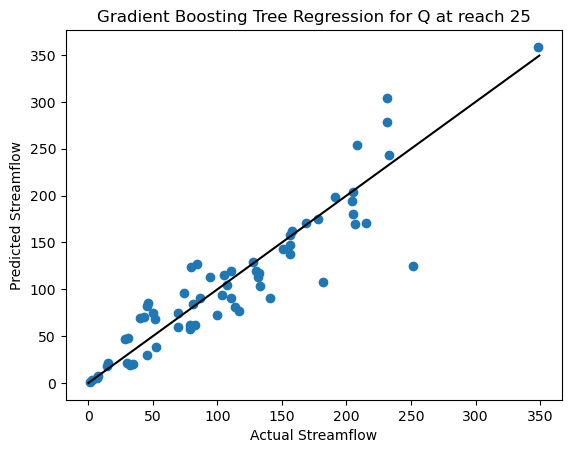

In [277]:
# Split dataset into training set and test set, default here is 30% test
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import trainAndEvaluateModel

t0 = time.time()
n = 1

#Splitter is random and max features is set to 1, note that 1.0 is all in the new Sklearn so this is a little confusing
    
#imp_df_gr, metrics_df_gr, y_test, y_pred = trainAndEvaluateModel(GradientBoostingRegressor, Stp_head_test_df, output_test[rn], best_pars_gr, 0.2, random_state)  

imp_df_gr, metrics_df_gr, gr_impurity, gr_tree, y_test, y_pred = trainAndEvaluateModel(GradientBoostingRegressor, SingleStpHeads, outputs, best_pars_gr, 0.2, n, random_state)  

t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

#print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[rn]> 0].index) / len(new_zone_q.index)))

#print(metrics_df_rand.mean(),metrics_df_rand.std())
print(metrics_df_gr.mean())
plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_test.max()) +1
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Gradient Boosting Tree Regression for Q at reach " + str(rn)
plt.title(title)

# meshtitle = 'Gradient Boosting \n Importance values for each cell in predicting flow at reach ' + str(rn)

# wellmesh_gr = plotImportance(imp_df_gr,SingleStpHeads, well_loc_df,1,1,rn,meshtitle)

In [271]:
#gr_imp_df.to_pickle('Drawdown_GB_Impdf.pkl')
treeimp = pd.DataFrame(gr_tree.feature_importances_)
#display(treeimp)
topFeats = treeimp[0].nlargest(5)
topFeatLocs = Tree.feature_names_in_[topFeats.index]
display(topFeats)
display(topFeatLocs)
display(well_loc_df.loc[topFeatLocs.astype('int')])

display(imp_df_gr)
MostImp = []
for i in range(n):
    MostImp.append(int(imp_df_gr[i].idxmax()))

locs, counts = np.unique(MostImp,return_counts=True)
print(locs,counts)
display(well_loc_df.loc[locs])

79      0.169839
1441    0.120090
1208    0.091987
993     0.090512
1040    0.065328
Name: 0, dtype: float64

array(['79', '1510', '1272', '1004', '1100'], dtype=object)

,0,1
79,4,19
1510,35,25
1272,30,27
1004,24,47
1100,26,47


,0
0,0.000000
1,0.000000
2,0.000000
3,0.000132
4,0.000965
...,...
2007,0.000000
2008,0.000000
2009,0.000115
2010,0.000811


[79] [1]


,0,1
79,4,19


C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:119: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


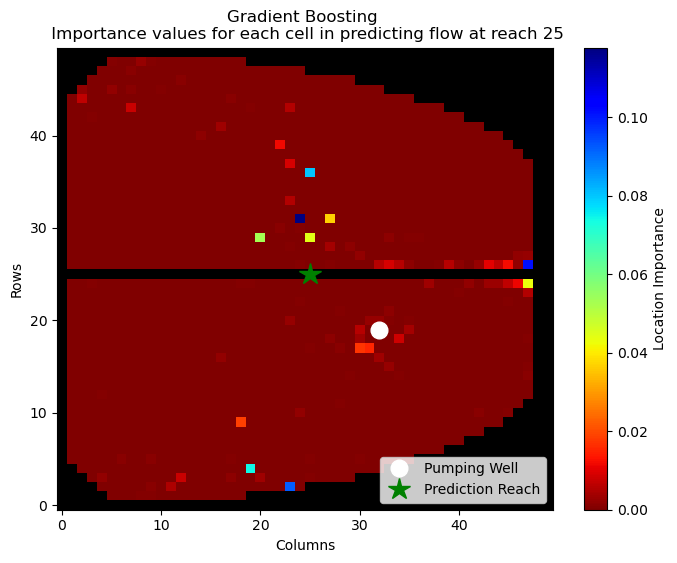

In [278]:
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import plotImportance

numTS = 1
#n = 100

title = 'Gradient Boosting \n Importance values for each cell in predicting flow at reach ' + str(rn)

wellmesh_gr = plotImportance(imp_df_gr,SingleStpHeads, well_loc_df,1,1,rn,title)



## Random Forest 

In [224]:
#new best RF
best_pars_rf = {'n_estimators': 175, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 5, 'max_samples': 0.9, 'max_leaf_nodes': None, 'max_depth': 7, 'criterion': 'squared_error'}


#best_pars_rf = {'n_estimators': 125, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 15, 'max_samples': 0.9, 'max_leaf_nodes': 154, 'max_features': 1.0, 'max_depth': 7, 'criterion': 'friedman_mse'}
#best_pars_rf = {'n_estimators': 125, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 15, 'max_samples': 0.9, 'max_leaf_nodes': 154, 'max_features': 1.0, 'max_depth': 7, 'criterion': 'friedman_mse'}
#best_pars_rf = {'max_depth': 4, 'criterion' : 'absolute_error','min_impurity_decrease': 0.01}

Shape of Input Samples: (318, 1941)
Shape of Output Targets: (318, 1)


C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Tree = Tree.fit(X_train,y_train)


Total time: 93.15111708641052
bias       3.880262
rmse      29.804707
r          0.916329
nse        0.836761
lognse     0.866777
kge        0.868665
dtype: float64


Text(0.5, 1.0, 'Random Forest Regression for predicting Q at reach 25')

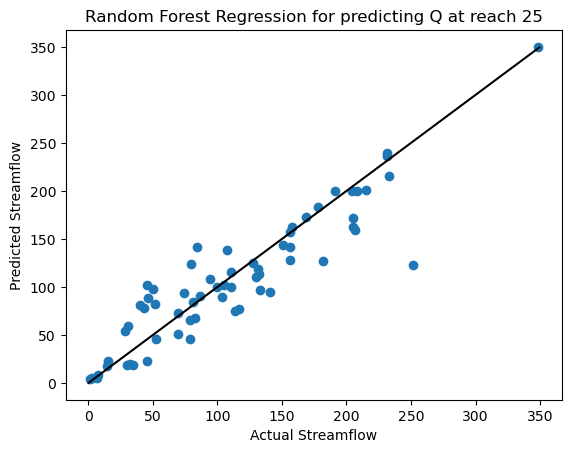

In [283]:
# Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n=1
rn = 25
#Splitter is random and max features is set to 1 (note that 1.0 is all in the new default all features in Sklearn so this is a little confusing)
    
#imp_df_rf, metrics_df_rf, impurity_list, rf_Tree, y_test, y_pred = trainAndEvaluateModel(RandomForestRegressor, Stp_head_test_df, output_test[rn], best_pars_rf, 0.2, n, random_state)  

imp_df_rf, metrics_df_rf, impurity_list, rf_Tree, y_test, y_pred = trainAndEvaluateModel(RandomForestRegressor, SingleStpHeads, outputs, best_pars_rf, 0.2, n, random_state)  

t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

#print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[rn]> 0].index) / len(new_zone_q.index)))

#print(metrics_df_rand.mean(),metrics_df_rand.std())
print(metrics_df_rf.mean())
plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_test.max()) +1

plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Random Forest Regression for predicting Q at reach " + str(rn)
plt.title(title)

In [281]:
#rf_imp_df.to_pickle('Drawdown_RF_Impdf.pkl')
# RF_rmse = round(metrics_df_rf.mean().loc['rmse'],2)
# print(RF_rmse)


display(imp_df_rf)
MostImp = []
for i in imp_df_rf.columns:
    MostImp.append(int(imp_df_rf[i].idxmax()))

locs, counts = np.unique(MostImp,return_counts=True)
print(locs,counts)
display(well_loc_df.loc[locs])

,0
0,0.000023
1,0.000075
2,0.000209
3,0.001627
4,0.003551
...,...
2007,0.000634
2008,0.000056
2009,0.000000
2010,0.000043


[1100] [1]


,0,1
1100,26,47


C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:119: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


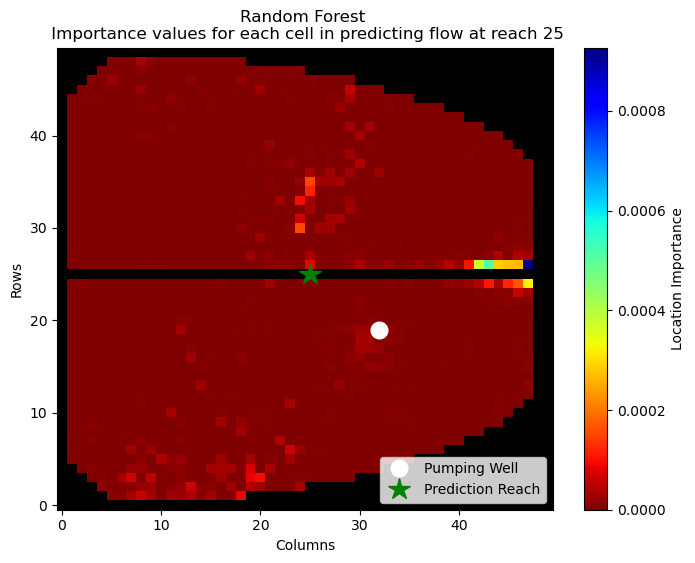

In [303]:
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import plotImportance

numTS = 1
#n = 100

title = 'Random Forest \n Importance values for each cell in predicting flow at reach ' + str(rn)# + '\n RMSE: ' + str(RF_rmse)

wellmesh_rf = plotImportance(imp_df_rf,SingleStpHeads, well_loc_df,numTS,n,rn,title)

In [ ]:
#set up the meshgrid   
kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)



river = np.ndarray((48,))
river[:] = 25

cmap_bd = cm.get_cmap("gray")#,lut=20)
cmap_bd.set_under("w")
cmap_bd.set_over("k")
wellmesh_bd = np.ndarray((50,50))
wellmesh_bd[:,:] = -1e30
for k in range(len(all_well_loc)):
        wellmesh_bd[int(all_well_loc[k, 1]), int(all_well_loc[k, 0])] = 2

cmap_rf = mp.colormaps.get_cmap("Greens")
wellmesh_rf_masked = np.ma.masked_array(wellmesh_rf, wellmesh_rf < 0.01)
vmaxrf = np.max(wellmesh_rf)

cmap_gr = mp.colormaps.get_cmap("Purples")
wellmesh_gr_masked = np.ma.masked_array(wellmesh_gr, wellmesh_gr < 0.01)
vmaxgr = np.max(wellmesh_gr)

cmap_dt = mp.colormaps.get_cmap("Blues")
wellmesh_dt_masked = np.ma.masked_array(wellmesh_df, wellmesh_df < 0.01)
vmaxdt = np.max(wellmesh_df)

vmin = 0.01
# combine them and build a new colormap
colors = np.vstack((cmap_rf(np.linspace(0.,1,128)), cmap_gr(np.linspace(0.,1,128)), cmap_dt(np.linspace(0.,1,128))))
print(colors)

mymap = mp.colors.LinearSegmentedColormap.from_list('Merged',colors)
fig, axs = plt.subplots(figsize=(10,12))
#plt.figure(figsize=(8,10))
alpha = 0.6
axs.pcolormesh(KK,GG,wellmesh_bd,vmax = 1.5,vmin = vmin, cmap = cmap_bd, shading='nearest', alpha = 0.05)
axs.pcolormesh(KK,GG,wellmesh_dt_masked,vmax = vmaxdt, vmin = vmin, cmap = cmap_dt, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Decision Tree", shrink = 0.25, pad = 0.05, anchor = (0,0.25), location ='bottom').set_ticks([])
axs.pcolormesh(KK,GG,wellmesh_rf_masked,vmax = vmaxrf, vmin = vmin, cmap = cmap_rf, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Random Forest", shrink = 0.25, anchor = (0.3,0.75), location ='bottom').set_ticks([])
axs.pcolormesh(KK,GG,wellmesh_gr_masked,vmax = vmaxgr, vmin = vmin, cmap = cmap_gr, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Gradient Boosted", shrink = 0.25, anchor = (0.75,1), location ='bottom').set_ticks([])
#plt.colorbar(cmap = mymap, location = 'bottom')


axs.plot(range(1,49),river, color="lightblue", label='River')
axs.plot(32, 21, marker="x", markersize=8, color="Black", linestyle = "None", label="Pumping Well")
axs.plot(rn, 25, marker="*", markersize=10, color="Red", linestyle = "None",label="Prediction Reach")
axs.set_xlabel('Columns')
axs.set_ylabel('Rows')
axs.set_title('Drawdown Scenario \n Importance values for each cell in predicting flow at reach ' + str(rn) + ' for all 3 ML Methods')
axs.legend(loc="lower right")
#axs[1].axis('off')
cbar = fig.colorbar(mp.cm.ScalarMappable(cmap=mymap), drawedges = False, ax = axs,label = 'Importance Gradients (darker = more important)', orientation = 'horizontal', ticks = [0,0.15,0.5,0.85,1],pad = 0.1, shrink = 0.75)
cbar.ax.set_xticklabels(['','Random Forest', 'Gradient Boosted','Decision Tree',''])
#plt.legend()